In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mnist = pd.read_csv('MNIST_dataset/test.csv')
mnist.head(5)

,label,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v347,x348,y348,v348,x349,y349,v349,x350,y350,v350
0,7,14,7,254,21,18,140,21,17,106,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,17,6,253,16,19,253,10,7,253,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,16,18,223,10,4,5,15,13,165,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,17,8,253,20,17,105,14,20,251,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,18,17,18,10,11,85,17,4,236,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [3]:
mnist = mnist.drop('label', axis = 1)

In [4]:
size = 100

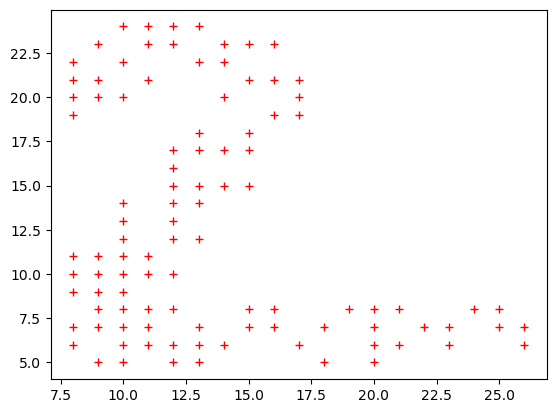

In [5]:
mapping = np.arange(3*size).reshape(-1, 3)
inds = mapping[:, :2]
val_ind = mapping[:, 2]
img = np.zeros((28, 28))
fisrt_img = mnist.to_numpy()[1]
coordinates = fisrt_img[inds]
img[coordinates[:,0], coordinates[:, 1]] = 1
plt.plot(coordinates[:,0], coordinates[:, 1], '+',color='red',)


In [6]:
mu, sigma = 0, 0.5 # mean and standard deviation
s1 = np.random.normal(mu, sigma, size)
s2 = np.random.normal(mu, sigma, size)

In [7]:
sqrt2d2 = np.sqrt(2)/2
R = np.array([[sqrt2d2, sqrt2d2], [-sqrt2d2, sqrt2d2]])
t = np.array([0.5, 0.5])
noise = np.hstack((s1.reshape(-1, 1), s2.reshape(-1, 1)))

In [8]:
from problem_instance.twoD_point_cloud_registeration import model, pairwise_compatibility_value, definite_graph, area_invariant_compatibility_test

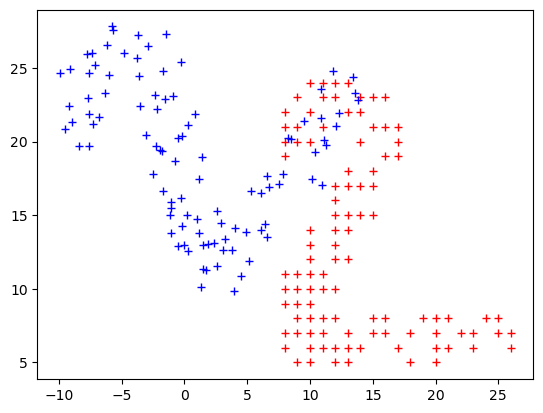

In [9]:
new_coord = model(R, t, coordinates, noise)
plt.plot(coordinates[:,0], coordinates[:, 1], '+', color='red')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='blue',)

In [10]:
outliers = 28 * np.random.rand(20, 2) # 20 outliers points in 2D
outliers_cord_t = model(R, t, outliers, np.zeros((20, 2)))

In [11]:
new_coord_with_outliers = np.vstack((new_coord[:-20], outliers_cord_t))

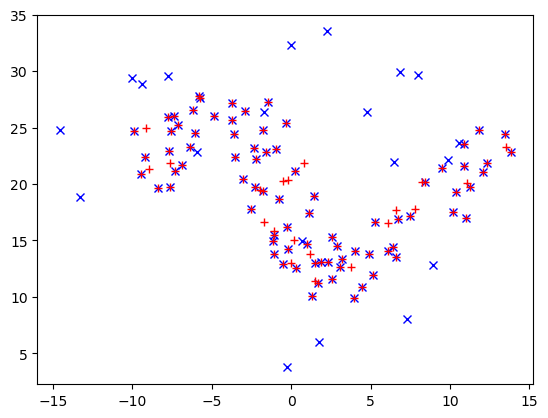

In [12]:
plt.plot(new_coord_with_outliers[:,0], new_coord_with_outliers[:, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

In [13]:
perm = np.random.permutation(size)
new_coord_with_outliers = new_coord_with_outliers[perm]
coordinates = coordinates[perm]

In [14]:
weigthed_G = pairwise_compatibility_value(coordinates, new_coord_with_outliers)
G = definite_graph(weigthed_G, 0.5)

In [15]:
from QUBO_formulation.qubo import solve_graph, definite_graph_to_qubo, weighted_graph_to_qubo, n_invariant_ordinary_graph_to_qubo

In [16]:
# import itertools
# indicies = np.arange(size)
# indices_pairs = itertools.product(indicies, indicies)
# list(indices_pairs)[-10:]

In [17]:
G.shape

(100, 100)

In [18]:
sl = solve_graph(G, "dwave_annealing", 0.01)

In [19]:
sol = np.argwhere(sl == 1).reshape(-1)

(100,)

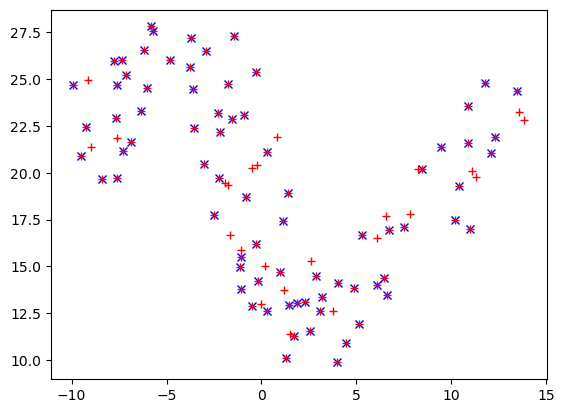

In [20]:
plt.plot(new_coord_with_outliers[sol, 0], new_coord_with_outliers[sol, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 100 columns and 0 nonzeros
Model fingerprint: 0xdbf352ce
Model has 3168 quadratic objective terms
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-02, 4e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -36.6400000
Found heuristic solution: objective -51.6800000
Presolve removed 0 rows and 25 columns
Presolve time: 0.02s
Presolved: 0 rows, 75 columns, 0 nonzeros
Presolved model has 2123 quadratic objective terms
Variable types: 0 continuous, 75 integer (75 binary)

Root relaxation: objective -5.17960

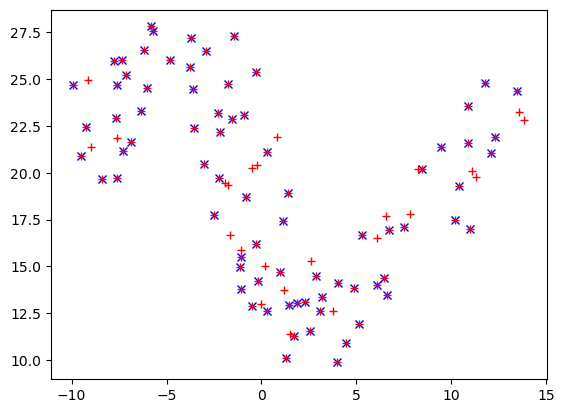

In [21]:
slg = solve_graph(G, "gurobi", 0.01)
solg = np.argwhere(sl == 1).reshape(-1)
plt.plot(new_coord_with_outliers[solg, 0], new_coord_with_outliers[solg, 1], 'x', color='blue')
plt.plot(new_coord[:,0], new_coord[:, 1], '+', color='red')